## This notebook is for visualising grids

In [1]:
# All imports should be in first cell
import netCDF4 as nc
import numpy as np
#from mpl_toolkits.basemap import Basemap
import cartopy
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib created a temporary config/cache directory at /vftmp/Niki.Zadeh/pid67708/matplotlib-72zoiyah because the default path (/home/Niki.Zadeh/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
#utility function to plot grids
PI_180 = np.pi/180.
def plot_mesh_in_latlon(lam, phi, stride=1, phi_color='k', lam_color='r', newfig=True, title=None):
    import matplotlib.pyplot as plt
#    import seaborn as sns; sns.set()
    if (phi.shape != lam.shape): raise Exception('Ooops: lam and phi should have same shape')
    nj,ni = lam.shape
    if(newfig):
        plt.figure(figsize=(10,10))
    for i in range(0,ni,stride):
        plt.plot(lam[:,i],phi[:,i],lam_color)
    for j in range(0,nj,stride):
        plt.plot(lam[j,:],phi[j,:],phi_color)
    if title is not None:
        plt.title(title)
#    plt.show()

def plot_mesh_in_xyz(lam, phi, stride=1, phi_color='k', lam_color='r', lowerlat=None, upperlat=None, newfig=True, title=None):
    if lowerlat is not None:
        lam,phi = cut_below(lam,phi,lowerlat=lowerlat)
    if upperlat is not None:
        lam,phi = cut_above(lam,phi,upperlat=upperlat)
    x = np.cos(phi*PI_180) * np.cos(lam*PI_180)
    y = np.cos(phi*PI_180) * np.sin(lam*PI_180)
    z = np.sin(phi*PI_180)
    plot_mesh_in_latlon(x, y, stride=stride, phi_color=phi_color, lam_color=lam_color, newfig=newfig, title=title)

def cut_below(lam,phi,lowerlat):
    nj,ni = lam.shape
    for j in range(0,nj):
        if(phi[j,0]>lowerlat):
            break
    jmin=j
#    print("jmin",jmin)
    return lam[jmin:,:], phi[jmin:,:]

def cut_above(lam,phi,upperlat):
    nj,ni = lam.shape
    for j in range(0,nj):
        if(phi[j,0]>upperlat):
            break
    jmax=j
#    print("jmax",jmax)
    return lam[0:jmax,:], phi[0:jmax,:]

def mesh_plot(lon,lat, lon0=0.,lat0=90.,color='k',ax=None):
    """Plot a given mesh with a perspective centered at (lon0,lat0)"""
    #
    if(ax is None):
        plt.figure(figsize=(12,12))
        ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=lon0, central_latitude=lat0))
        ax.set_global()
        ax.stock_img()
        ax.coastlines()
        ax.gridlines()
    (nj,ni) = lon.shape 
    for i in range(0,ni+1,2):
        ax.plot(lon[:,i], lat[:,i], color, transform=cartopy.crs.Geodetic())
    for j in range(0,nj+1,2):
        ax.plot(lon[j,:], lat[j,:], color, transform=cartopy.crs.Geodetic())
    return ax

def mesh_plot1(lon,lat, lon0=0.,lat0=90.,color='k',ax=None):
    """Plot a given mesh with a perspective centered at (lon0,lat0)"""
    #
    if(ax is None):
        plt.figure(figsize=(12,12))
        ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=lon0, central_latitude=lat0))
        ax.set_global()
        ax.stock_img()
        ax.coastlines()
        ax.gridlines()
    (nj,ni) = lon.shape 
    for i in range(0,ni):
        ax.plot(lon[:,i], lat[:,i], color, transform=cartopy.crs.Geodetic())
    for j in range(0,nj):
        ax.plot(lon[j,:], lat[j,:], color, transform=cartopy.crs.Geodetic())
    return ax

def points_plot(lon,lat, lon0=0.,lat0=90.,color='k',ax=None):
    """Plot a given array of point""" 
    ax.plot(lon, lat, color, transform=cartopy.crs.Geodetic())#transform=cartopy.crs.PlateCarree())
    return ax


## Read the target grid

In [3]:
def read_cs_mesh(pathname,pole=None):
    import netCDF4     
    #Read in target grid
    targ_lon_tile=[]
    targ_lat_tile=[]
    for tile in range(1,7):
        targ_grid =  netCDF4.Dataset(pathname+str(tile)+'.nc')
        targ_lon=np.array(targ_grid.variables['x'])
        targ_lat=np.array(targ_grid.variables['y'])
        if(tile==4 or tile==5 or tile==6):
            targ_lon=np.transpose(targ_lon)
            targ_lat=np.transpose(targ_lat)
        print("Tile"+str(tile))
        print(" Target mesh shape: ",targ_lon.shape)
        print(" Target mesh corner ll: ",targ_lon[0,0],targ_lat[0,0])
        print(" Target mesh corner ur: ",targ_lon[-1,-1],targ_lat[-1,-1])

        if(tile==1 and not np.all(np.diff(targ_lon[0,:])>0)):
            print("   Longitude array is not monotonic. Shifting to make it so...")
            #Niki: come up with a better scheme to remove 60
            targ_lon = np.where(targ_lon>60 , targ_lon-360, targ_lon)
        if(not np.all(np.diff(targ_lon[0,:])>0)):
            print(" Error: Longitude array is still not monotonic!")

        targ_lon_tile.append(targ_lon)
        targ_lat_tile.append(targ_lat)
            
        lond=targ_lon[0,0]
        latd=targ_lat[0,0]
        lonu=targ_lon[0,-1]
        latu=targ_lat[-1,0]
        lonc=0.5*(lond+lonu)
        latc=0.5*(latd+latu)
        if((targ_lat[1,1]-targ_lat[0,0])*(targ_lat[-1,-1]-targ_lat[-2,-2]) < 0):
            if((targ_lat[1,1]-targ_lat[0,0]) < 0):
                print("Has South pole, tile ",tile)
                latc=-90.
                if(pole == "South"):
                    return targ_lon,targ_lat,lonc,latc
            else:
                print("Has North pole, tile ",tile)
                latc=90.  
                if(pole == "North"):
                    return targ_lon,targ_lat,lonc,latc

    return targ_lon_tile,targ_lat_tile

 

In [4]:
pathname='/work/Niki.Zadeh/mosaic_generation/exchange_grid_toolset/'

In [5]:
pathname32=pathname+'mosaic_c256r25tlat32.0_om4p25/' 
o_grid =  nc.Dataset(pathname32 + 'ocean_hgrid.nc')
o_lon=np.array(o_grid.variables['x'])
o_lat=np.array(o_grid.variables['y'])
o_lon.shape

(1153, 1441)

In [6]:
cs_lon,cs_lat=read_cs_mesh(pathname32 + 'C256_grid.tile')

Tile1
 Target mesh shape:  (513, 513)
 Target mesh corner ll:  279.249274247122 14.372958013338977
 Target mesh corner ur:  212.51598193890476 -26.52563982263032
   Longitude array is not monotonic. Shifting to make it so...
 Error: Longitude array is still not monotonic!
Has South pole, tile  1
Tile2
 Target mesh shape:  (513, 513)
 Target mesh corner ll:  245.55072575287795 14.372958013338971
 Target mesh corner ur:  160.14112471304702 45.55640082439432
 Error: Longitude array is still not monotonic!
Tile3
 Target mesh shape:  (513, 513)
 Target mesh corner ll:  212.51598193890476 -26.52563982263032
 Target mesh corner ur:  4.65887528695287 45.55640082439434
 Error: Longitude array is still not monotonic!
Has South pole, tile  3
Tile4
 Target mesh shape:  (513, 513)
 Target mesh corner ll:  160.14112471304702 45.55640082439432
 Target mesh corner ur:  286.4377886377425 46.42453420122189
 Error: Longitude array is still not monotonic!
Has North pole, tile  4
Tile5
 Target mesh shape: 

<GeoAxesSubplot:>

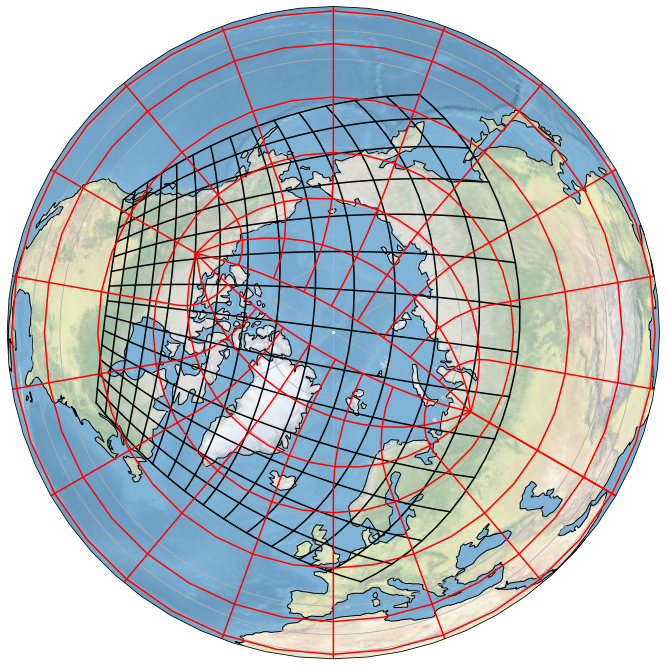

In [7]:
lonc=0.
latc=90.
ax=mesh_plot(cs_lon[3][::18,::18],cs_lat[3][::18,::18],lon0=lonc,lat0=latc)
mesh_plot(o_lon[::40,::40],o_lat[::40,::40],color='r',ax=ax)

<GeoAxesSubplot:>

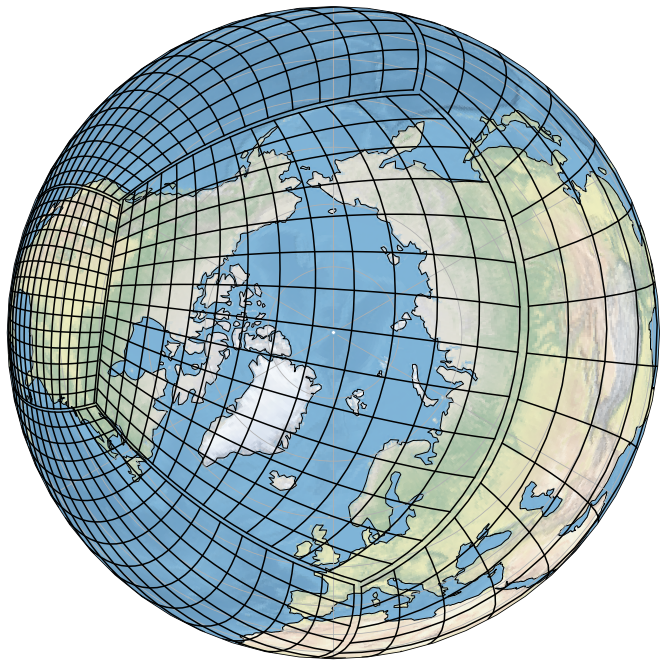

In [19]:
lonc=0.
latc=90.
ax=mesh_plot(cs_lon[1][::18,::18],cs_lat[1][::18,::18])
mesh_plot(cs_lon[2][::18,::18],cs_lat[2][::18,::18],ax=ax) #,lon0=lonc,lat0=latc)
mesh_plot(cs_lon[3][::18,::18],cs_lat[3][::18,::18],ax=ax)
mesh_plot(cs_lon[4][::18,::18],cs_lat[4][::18,::18],ax=ax)
mesh_plot(cs_lon[5][::18,::18],cs_lat[5][::18,::18],ax=ax)
#mesh_plot(o_lon[::40,::40],o_lat[::40,::40],color='r',ax=ax)

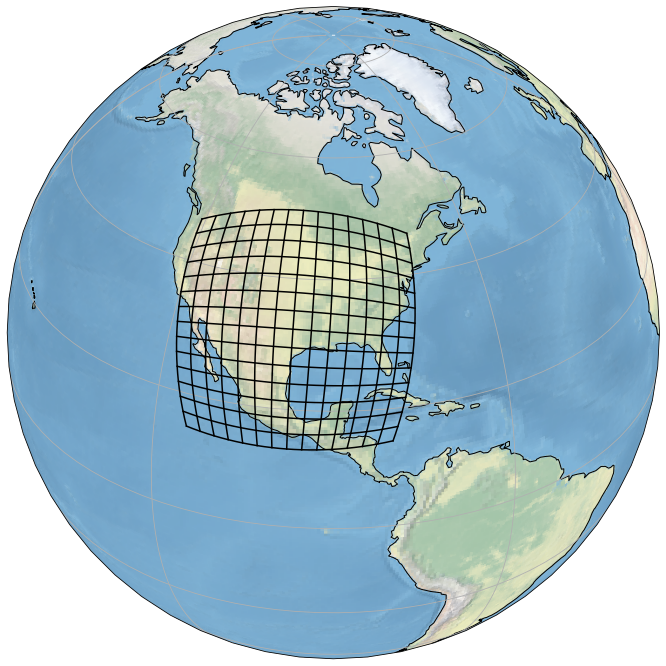

In [22]:
lonc=0.
latc=90.
ax=mesh_plot(cs_lon[5][::18,::18],cs_lat[5][::18,::18],lon0=270,lat0=32)
#mesh_plot(o_lon[::40,::40],o_lat[::40,::40],color='r',ax=ax)

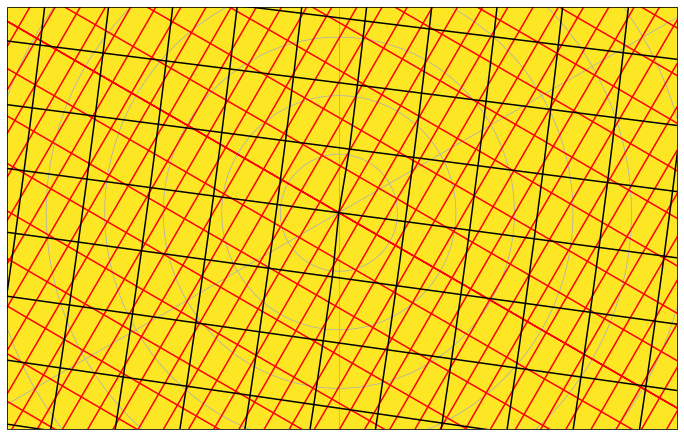

In [8]:
ocean_mask_file = pathname32+'ocean_mask.nc'
ocean_mask = nc.Dataset(ocean_mask_file)
Omask = np.array(ocean_mask.variables['mask'])
plt.figure(figsize=(12,12))
ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=lonc, central_latitude=latc))
#ax = plt.subplot(111, projection=cartopy.crs.NorthPolarStereo(central_longitude=lonc))
ax.set_global()
#ax.stock_img()
#ax.coastlines()
ax.gridlines()
ax.pcolormesh(o_lon[::2,::2],o_lat[::2,::2],Omask, transform=cartopy.crs.PlateCarree())
mesh_plot(o_lon[::,::],o_lat[::,::],color='r',ax=ax)
mesh_plot(cs_lon[3][::,::],cs_lat[3][::,::],ax=ax)
ax.set_extent([-300,60,88,90],cartopy.crs.PlateCarree())

## There was an anomaly in land mask near the south pole for the targ_lat=32N stretched grid. It occurs where there is no ocean grid. The ocean grid does not cover the whole of the southern cap and stops at -85S.

### So the problem here must be arising from ATM grid cell area calculation. 

## Again the problem goes away when using a great-circle-algorithm grid for ATM.

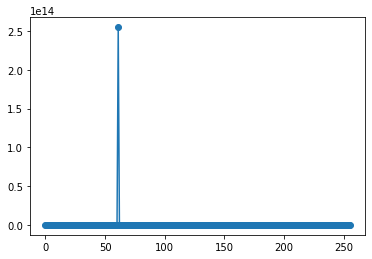

In [9]:
pathname320='/work/Niki.Zadeh/MOM6-examples_myfork/ice_ocean_SIS2/OM4_025/preprocessing.20201028/mosaic_c256r25tlat32.0_om4p25_githubMaster_Verbose_20210121/'          
land_mask0 = nc.Dataset(pathname320+'land_mask_tile3.nc')
mask320= np.array(land_mask0.variables['mask'])
area_atm320= np.array(land_mask0.variables['area_atm'])
plt.plot(area_atm320[128,:],marker='o')

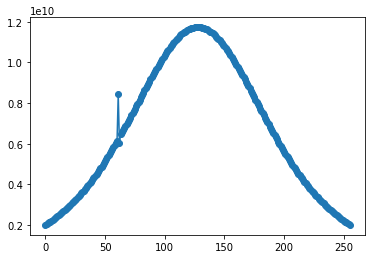

In [10]:
land_mask_t3 = nc.Dataset(pathname32+'land_mask_tile3.nc')
area_atm32_t3= np.array(land_mask_t3.variables['area_atm'])
plt.plot(area_atm32_t3[128,:],marker='o')

mask32_t3= np.array(land_mask_t3.variables['mask'])

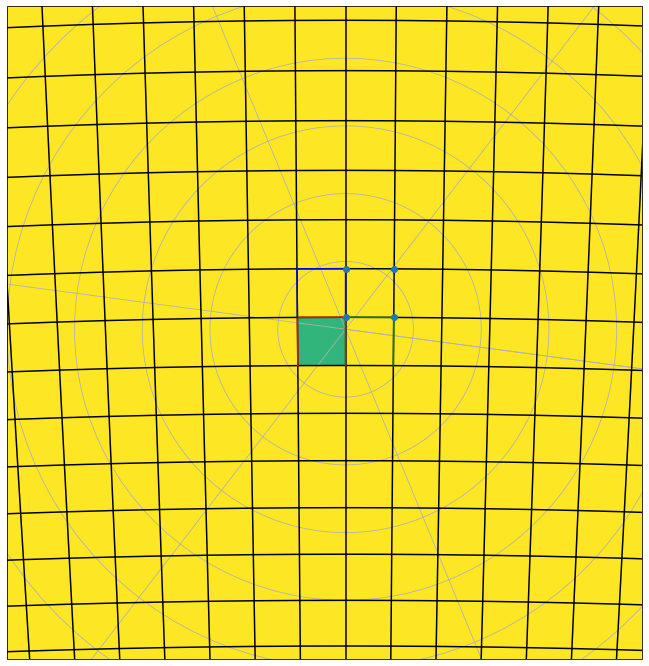

In [11]:
plt.figure(figsize=(12,12))
ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=82.4, 
                                                                 central_latitude=-90))
ax.set_global()
#ax.stock_img()
#ax.coastlines()
#ax.gridlines()
ax.pcolormesh(cs_lon[2][::2,::2],cs_lat[2][::2,::2],mask32_t3, transform=cartopy.crs.PlateCarree())
mesh_plot(cs_lon[2],cs_lat[2],lon0=60,lat0=-90,ax=ax)
#mesh_plot(o_lon[::10,::10],o_lat[::10,::10],color='r',ax=ax)
l0=100.
ax.set_extent([l0,360.+l0,-90,-85],cartopy.crs.PlateCarree())
#ax._threshold /= 100.
#ax = plt.axes(projection=ax)
ax.gridlines()
sq1=np.array([[262.40000000000, -89.46584623220],[82.4, -89.82370183256], 
       [6.19743837887, -89.26896927380],[-44.88793552504, -89.11514201451]]).T 
sq2=np.array([[  82.4, -89.82370183256 ],[ 82.4, -89.10746816044 ],
             [ 43.60348402380, -88.85737639760 ],[ 6.19743837887, -89.26896927380]]).T
sq3=np.array([[ 209.68793552504, -89.11514201451],[158.60256162113, -89.26896927380], 
[82.40000000000,-89.82370183256],[262.40000000000, -89.46584623220]]).T 
sq4=np.array([[ 158.60256162113, -89.26896927380],[121.19651597620, -88.85737639760 ],
[82.40000000000, -89.10746816044 ],[82.40000000000, -89.82370183256]]).T 
points_plot(sq1[0,:],sq1[1,:],color='r',ax=ax)
points_plot(sq2[0,:],sq2[1,:],color='b',ax=ax)
points_plot(sq3[0,:],sq3[1,:],color='g',ax=ax)
points_plot(sq4[0,:],sq4[1,:],color='o',ax=ax)
plt.show()

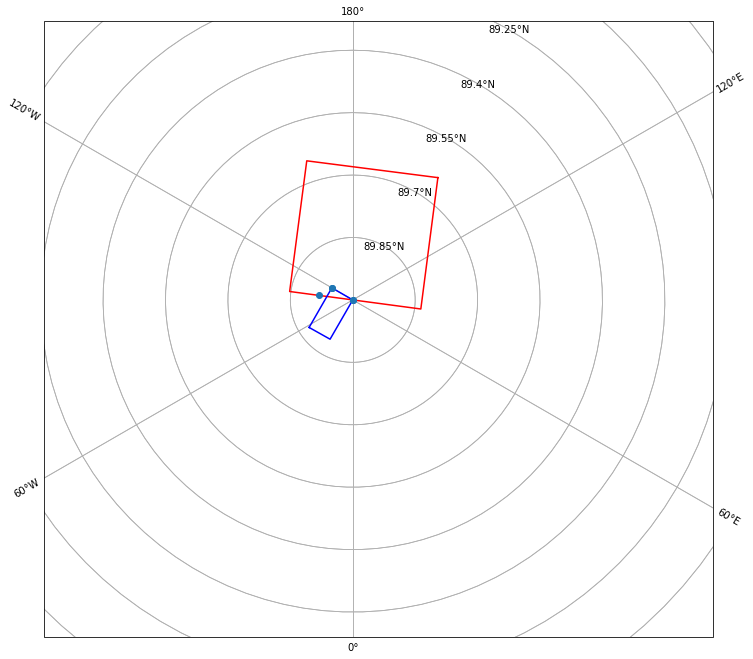

In [12]:
def points_plot2(lon,lat, lon0=0.,lat0=90.,color='k',ax=None):
    """Plot a given array of point""" 
    ax.plot(lon, lat, color,transform=cartopy.crs.PlateCarree())
    return ax

plt.figure(figsize=(12,12))
axNP = plt.subplot(111, projection=cartopy.crs.NorthPolarStereo(central_longitude=0.))
axNP.gridlines()

sq1=np.array([[145.159, 198.302, 262.400, 262.400,  82.400,  82.400,145.159],
              [ 89.642,  89.648,  89.847,  90.000,  90.000,  89.835,89.642]])
sq2=np.array([[302.252, 330.000, 330.000, 240.000, 240.000,302.252],
              [89.876,  89.891,  90.000,  90.000,  89.942, 89.876]])
sq3=np.array([[240,240,262.4,262.4,240],[89.942, 90,  90,  89.9183,89.942 ]])
points_plot2(sq1[0,:],sq1[1,:],color='r',ax=axNP)
points_plot2(sq2[0,:],sq2[1,:],color='b',ax=axNP)
points_plot2(sq3[0,:],sq3[1,:],color='o',ax=axNP)

axNP.gridlines(draw_labels=True, crs=cartopy.crs.PlateCarree())

axNP.set_extent([-300,60,89,90],cartopy.crs.PlateCarree())
plt.show()

In [24]:
import xarray
ds = xarray.open_dataset(pathname32 + 'ocean_hgrid.nc')

In [25]:
ds

<xarray.Dataset>
Dimensions:   (nx: 1440, nxp: 1441, ny: 1152, nyp: 1153)
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    tile      |S255 ...
    y         (nyp, nxp) float64 ...
    x         (nyp, nxp) float64 ...
    dy        (ny, nxp) float64 ...
    dx        (nyp, nx) float64 ...
    area      (ny, nx) float64 ...
    angle_dx  (nyp, nxp) float64 ...

In [26]:
def read_cs_mesh_xr(pathname,pole=None):
    import xarray     
    #Read in target grid
    targ_lon_tile=[]
    targ_lat_tile=[]
    for tile in range(1,7):
        targ_grid =  xarray.open_dataset(pathname+str(tile)+'.nc')
        targ_lon=np.array(targ_grid.variables['x'])
        targ_lat=np.array(targ_grid.variables['y'])
        if(tile==4 or tile==5 or tile==6):
            targ_lon=np.transpose(targ_lon)
            targ_lat=np.transpose(targ_lat)
        print("Tile"+str(tile))
        print(" Target mesh shape: ",targ_lon.shape)
        print(" Target mesh corner ll: ",targ_lon[0,0],targ_lat[0,0])
        print(" Target mesh corner ur: ",targ_lon[-1,-1],targ_lat[-1,-1])

        if(tile==1 and not np.all(np.diff(targ_lon[0,:])>0)):
            print("   Longitude array is not monotonic. Shifting to make it so...")
            #Niki: come up with a better scheme to remove 60
            targ_lon = np.where(targ_lon>60 , targ_lon-360, targ_lon)
        if(not np.all(np.diff(targ_lon[0,:])>0)):
            print(" Error: Longitude array is still not monotonic!")

        targ_lon_tile.append(targ_lon)
        targ_lat_tile.append(targ_lat)
            
        lond=targ_lon[0,0]
        latd=targ_lat[0,0]
        lonu=targ_lon[0,-1]
        latu=targ_lat[-1,0]
        lonc=0.5*(lond+lonu)
        latc=0.5*(latd+latu)
        if((targ_lat[1,1]-targ_lat[0,0])*(targ_lat[-1,-1]-targ_lat[-2,-2]) < 0):
            if((targ_lat[1,1]-targ_lat[0,0]) < 0):
                print("Has South pole, tile ",tile)
                latc=-90.
                if(pole == "South"):
                    return targ_lon,targ_lat,lonc,latc
            else:
                print("Has North pole, tile ",tile)
                latc=90.  
                if(pole == "North"):
                    return targ_lon,targ_lat,lonc,latc

    return targ_lon_tile,targ_lat_tile

 

In [27]:
cs_lon_xr,cs_lat_xr=read_cs_mesh_xr(pathname32 + 'C256_grid.tile')

Tile1
 Target mesh shape:  (513, 513)
 Target mesh corner ll:  279.249274247122 14.372958013338977
 Target mesh corner ur:  212.51598193890476 -26.52563982263032
   Longitude array is not monotonic. Shifting to make it so...
 Error: Longitude array is still not monotonic!
Has South pole, tile  1
Tile2
 Target mesh shape:  (513, 513)
 Target mesh corner ll:  245.55072575287795 14.372958013338971
 Target mesh corner ur:  160.14112471304702 45.55640082439432
 Error: Longitude array is still not monotonic!
Tile3
 Target mesh shape:  (513, 513)
 Target mesh corner ll:  212.51598193890476 -26.52563982263032
 Target mesh corner ur:  4.65887528695287 45.55640082439434
 Error: Longitude array is still not monotonic!
Has South pole, tile  3
Tile4
 Target mesh shape:  (513, 513)
 Target mesh corner ll:  160.14112471304702 45.55640082439432
 Target mesh corner ur:  286.4377886377425 46.42453420122189
 Error: Longitude array is still not monotonic!
Has North pole, tile  4
Tile5
 Target mesh shape: 

<GeoAxesSubplot:>

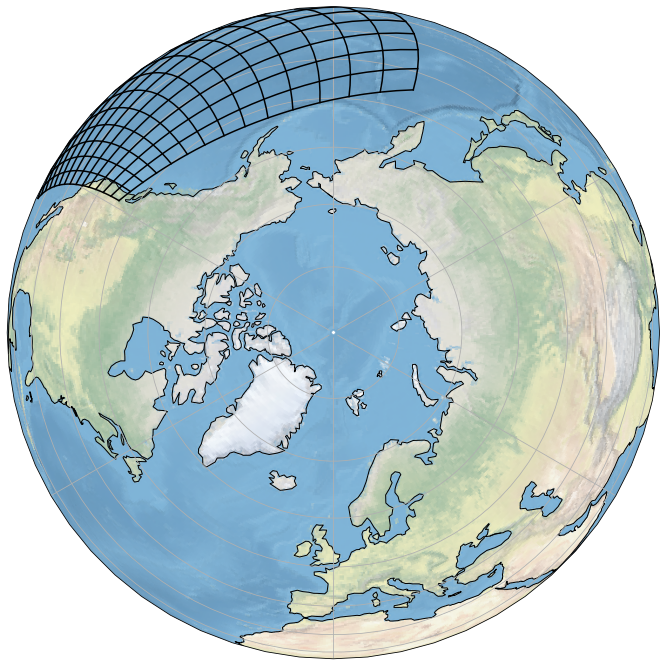

In [28]:
mesh_plot(cs_lon_xr[1][::18,::18],cs_lat_xr[1][::18,::18])